In [1]:
import rasterio as rio
import numpy as np
from landsat_processing_utils import histogram_stretch
from rasterio.plot import show
from scipy.ndimage import generic_filter, uniform_filter

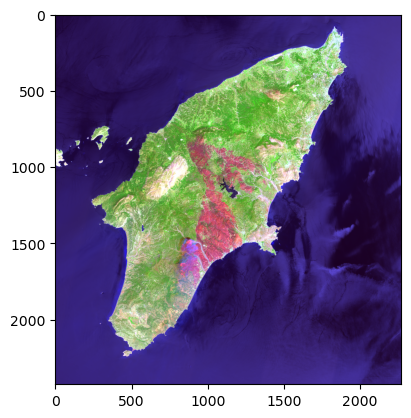

<Axes: >

In [6]:
# View image
with rio.open('20230726_TOA/LC08_L1TP_180035_20230726_20230804_02_T1_TOA_STACKED.tif') as src:
    profile = src.profile
    stack = src.read()
    src.close()
    
stretch_tcc = histogram_stretch(stack[[6,4,1],...], 0, 99)

show(stretch_tcc)

In [7]:
# Extract stacks for clarity
band = dict()

for i in range(7):
    band[i+1] = stack[i, ...]

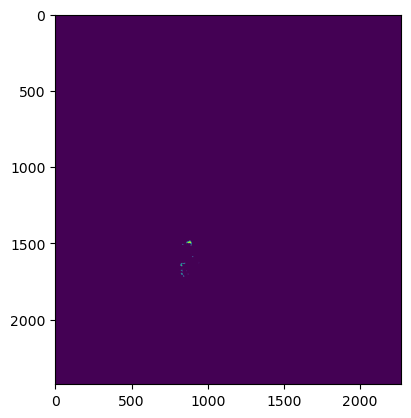

<Axes: >

In [8]:
### Active Fire Detection

# Attempt to detect active fire pixels based on the following condition:
# R75 > 2.5 AND p7-p5 > 0.3 AND p7 > 0.5

# UAFP = unambiguous active fire pixel
def unambiguous_fire(band):
    '''
    Input: Dictionary containing bands with keys 1-7
    
    Returns a NumPy boolean array containing true values where unambiguous 
    fire pixels were detected.
    '''
    uafp = ((band[7] / band[5]) > 2.5) & ((band[7] - band[5]) > 0.3) & (band[7] > 0.5)
    return uafp

fire_mask = unambiguous_fire(band)

show(fire_mask)

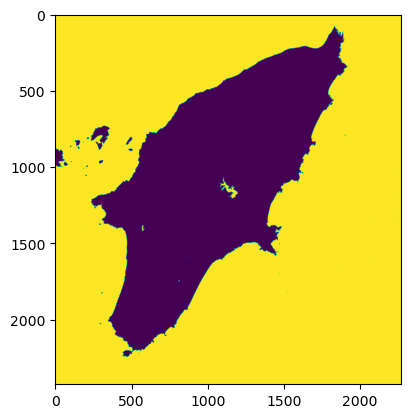

<Axes: >

In [9]:
def water(band):
    '''
    Used to detect water pixels (both ocean and inland water bodies)
    
    Input: Dictionary containing bands with keys 1-7
    
    Returns a NumPy boolean array containing true values where water pixels were detected.
    '''
    condition_1 = band[4] > band[5]
    condition_2 = band[5] > band[6]
    condition_3 = band[6] > band[7]
    condition_4 = (band[1] - band[7]) < 0.2
    
    test_1 = (condition_1 & condition_2 & condition_3 & condition_4)
    
    condition_5 = band[3] > band[2]
    condition_6 = band[1] > band[2]
    condition_7 = band[2] > band[3]
    condition_8 = band[3] > band[4]
    
    test_2 = ((condition_5) | (condition_6 & condition_7 & condition_8))
    
    return (test_1 & test_2)
    
water_mask = water(band)

show(water_mask)

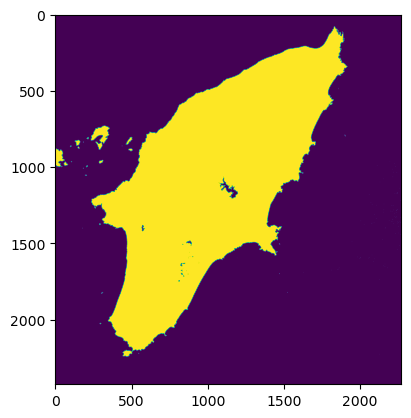

<Axes: >

In [10]:
def background(unambiguous_array, water_array):
    '''
    Used to identify valid background pixels. These pixels are used in the calculation of the mean and stddev values required
    for threshold and contextual tests for potential fire pixel detection
    
    Returns a boolean array indicating whether a pixel is a valid background pixel.
    '''
    # background array is anything that isn't a unambgiuous fire OR water pixel
    background = np.invert(unambiguous_array | water_array)
    
    # and band[7] > 0
    background = (background & (band[7] > 0))
    
    return background

background_mask = background(fire_mask, water_mask)

show(background_mask)

In [35]:
def potential_fire(band, background_mask):
    '''
    This helps classify potential fire pixels. First, it conducts threshold and contextual tests to determine if the 
    pixel is valid, then checks if it meets the other requirements.
    
    '''
    background_mask = np.invert(background_mask)
    ratio75 = np.where(background_mask, band[7] / band[5], np.nan)
    
    
    subcondition_1 = np.max(3 * generic_filter(ratio75, np.nanstd, [61,61]) , 0.8)
    

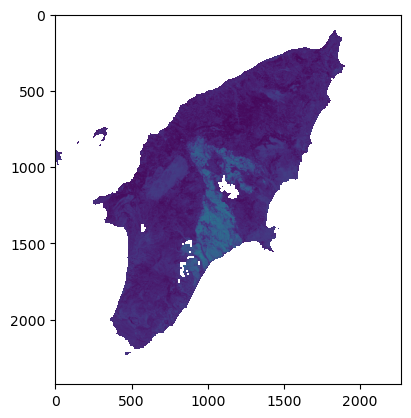

<Axes: >

In [18]:
ratio75 = np.where(background_mask, band[7] / band[5], np.nan)

show(ratio75)

In [ ]:
%%time
# def nan_std(image):
#     try:
#         return np.nanstd(image)
#     except:
#         return np.nan

sigma_75 = generic_filter(ratio75, np.nanstd, (61,61))

sigma_75

In [2]:
test = np.arange(1,82).reshape(9,9)

test_mask = np.zeros((9,9))

test_mask[1:4,1:4] = 1

test_masked = np.where(test_mask, test, np.nan)

test_masked

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, 11., 12., 13., nan, nan, nan, nan, nan],
       [nan, 20., 21., 22., nan, nan, nan, nan, nan],
       [nan, 29., 30., 31., nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan]])

In [5]:
# ndimage does NOT respect masks - need to mask the image manually with np.nan
# then use the appropriate np function that ignores np.nan
# test_filter = generic_filter(test_masked, np.nanstd, (3,3))
test_filter = uniform_filter(test_masked, size = 3)

test_filter

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan]])

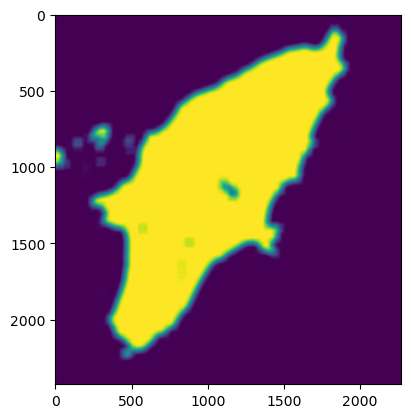

<Axes: >

In [15]:
bg_mask = background_mask.astype(np.float32)
weights = uniform_filter(bg_mask.astype(np.float32), size = 61)

show(weights)

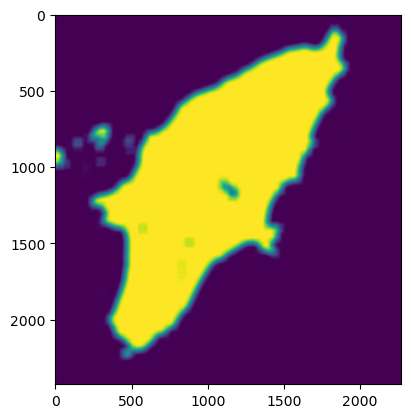

<Axes: >

In [14]:
show(weights)